## Importações

In [3]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from transformers import pipeline
import json
import re
from chromadb.config import Settings
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
from chromadb.utils.embedding_functions import DefaultEmbeddingFunction
from uuid import uuid4


c:\Users\Stella Sposito\Desktop\api\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Análise Exploratória dos dois dataframes de interesse

### Dataset reviews

#### Análise inicial

In [ ]:
review = pd.read_csv('reviews.csv')

In [3]:
review

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [4]:
# Verificando a quantidade de nulos antes de gerar embeddings
print('Valores nulos de cada coluna:')
review.isnull().sum()

Valores nulos de cada coluna:


review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

#### Entendendo os casos duplicados

In [5]:
review.duplicated().sum()

0

In [6]:
review.duplicated(subset='order_id').sum()

551

In [7]:
df_duplicados = review[review.duplicated(subset='order_id', keep=False)]

In [8]:
df_duplicados

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
30,540e7bbb2d06cfb7f85f3a88ba7ac97f,cf73e2cb1f4a9480ed70c154da3d954a,5,NaN,NaN,2018-01-18 00:00:00,2018-01-18 19:12:30
344,a0a641414ff718ca079b3967ef5c2495,169d7e0fd71d624d306f132acd791cbe,5,NaN,NaN,2018-03-04 00:00:00,2018-03-06 20:12:53
498,505a882ba08a689682a4afc6eb4e5965,1c308eca3f339414a92e518e2a2e5ee9,2,NaN,NaN,2017-12-28 00:00:00,2017-12-31 20:25:02
764,c5976a5a98e854fb23d7e03c6754ae60,2002ea16e75277eaa0b5d78632048540,5,NaN,NaN,2017-08-08 00:00:00,2017-08-10 11:11:29
778,62c7722239b976d943ec0d430cfe890e,1d297b4800ed1a3c5b0944d84c01ee99,3,NaN,NaN,2017-10-22 00:00:00,2017-10-31 15:33:32
...,...,...,...,...,...,...,...
98989,dfb3db02188d809d5cd199496b6da87e,c0db7d31ace61fc360a3eaa34dd3457c,5,NaN,NaN,2018-02-17 00:00:00,2018-02-19 19:29:19
99108,2c6c08892b83ba4c1be33037c2842294,42ae1967f68c90bb325783ac55d761ce,4,NaN,"Chegou um pouco amassada, mas nada de mais, e ...",2017-07-03 00:00:00,2017-07-05 19:06:59
99164,2afe63a67dfd99b3038f568fb47ee761,c5334d330e36d2a810a7a13c72e135ee,5,NaN,"Muito bom, produto conforme anunciado, entrega...",2018-03-03 00:00:00,2018-03-04 22:56:47
99178,44d1e9165ec54b1d89d33594856af859,a7dbcf5043158d6fa72859eead2f3d10,4,NaN,NaN,2017-05-24 00:00:00,2017-05-24 23:15:21


In [9]:
# Verificando duplicados com review nulo e não nulo
review[review['order_id'] == '42ae1967f68c90bb325783ac55d761ce']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
8217,193d73d33b656807084215db91b23b8c,42ae1967f68c90bb325783ac55d761ce,3,NaN,NaN,2017-07-19 00:00:00,2017-07-19 12:22:10
99108,2c6c08892b83ba4c1be33037c2842294,42ae1967f68c90bb325783ac55d761ce,4,NaN,"Chegou um pouco amassada, mas nada de mais, e ...",2017-07-03 00:00:00,2017-07-05 19:06:59


- Mesmo com o mesmo order_id, o review_score pode ser diferente, assim como o restante das colunas, então um mesmo order_id pode ter avaliações diferentes

### Dataset order_items

#### Análise antes do merge

- Para juntar com o product_id, vamos manter os registros de order_id da tabela de reviews e fazer o merge

In [10]:
order = pd.read_csv('olist_order_items_dataset.csv')

In [11]:
order

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [12]:
order.duplicated().sum()

0

In [13]:
order.duplicated(subset='order_id').sum()

13984

In [14]:
df_duplicados = order[order.duplicated(subset='order_id', keep=False)]

In [15]:
df_duplicados

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
...,...,...,...,...,...,...,...
112635,fff8287bbae429a99bb7e8c21d151c41,2,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-03-27 12:29:22,180.00,48.14
112640,fffb9224b6fc7c43ebb0904318b10b5f,1,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19


In [16]:
# Contar quantos product_ids únicos cada order_id tem
count_product = order.groupby('order_id')['product_id'].nunique()

# Ver quantos order_ids têm mais de 1 product_id
order_ids_mult = (count_product > 1).sum()
print(f"Quantidade de order_ids com múltiplos product_ids: {order_ids_mult}")

Quantidade de order_ids com múltiplos product_ids: 3236


- O mesmo order_id pode aparecer para diferentes produtos, como queremos apenas as reviews de produtos da tabela review, faremos um left join

#### Merge

In [17]:
df = review.merge(order, how='left', on='order_id')

In [18]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113126,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,1.0,4fb209073dc2ab6a6d3c259a7c285501,5343d0649eca2a983820bfe93fc4d17e,2018-07-02 17:30:37,226.77,61.20
113127,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,1.0,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,2017-12-07 22:08:00,199.99,9.77
113128,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,2018-03-22 10:08:04,215.97,15.59
113129,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,1.0,73a7fbf8c1048131f3b531af31bcdf0e,8d956fec2e4337affcb520f56fd8cbfd,2018-06-26 18:15:29,50.95,15.46


In [19]:
# Filtrar linhas onde todas as 3 colunas são nulas
all_null = df[
    df['review_comment_message'].isnull() & 
    df['review_comment_title'].isnull() & 
    df['review_score'].isnull()
]

product_ids_allnull = all_null['product_id'].unique()
print(f"Product_ids com todas as 3 colunas nulas: {len(product_ids_allnull)}")
print(product_ids_allnull[:10])  # primeiros 10

Product_ids com todas as 3 colunas nulas: 0
[]


- Caso tivesse algum produto sem review score, review title e review comment, ele seria excluído

## Análise Dataframe com merge entre = reviews e order_items

### Quantas colunas e linhas temos no nosso dataframe? Existem valores nulos? 

In [20]:
# Verificando os tipos das colunas
df.info()
print('\n')
print(f'Quantidade de linhas: {df.shape[0]}')
print(f'Quantidade de colunas: {df.shape[1]}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113131 entries, 0 to 113130
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   review_id                113131 non-null  object 
 1   order_id                 113131 non-null  object 
 2   review_score             113131 non-null  int64  
 3   review_comment_title     13523 non-null   object 
 4   review_comment_message   48166 non-null   object 
 5   review_creation_date     113131 non-null  object 
 6   review_answer_timestamp  113131 non-null  object 
 7   order_item_id            112372 non-null  float64
 8   product_id               112372 non-null  object 
 9   seller_id                112372 non-null  object 
 10  shipping_limit_date      112372 non-null  object 
 11  price                    112372 non-null  float64
 12  freight_value            112372 non-null  float64
dtypes: float64(3), int64(1), object(9)
memory usage: 11.2+ MB



In [21]:
df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       99608
review_comment_message     64965
review_creation_date           0
review_answer_timestamp        0
order_item_id                759
product_id                   759
seller_id                    759
shipping_limit_date          759
price                        759
freight_value                759
dtype: int64

In [22]:
print(f'A porcentagem de nulos de cada coluna é:\n{(df.isnull().sum() / df.shape[0])}')

A porcentagem de nulos de cada coluna é:
review_id                  0.000000
order_id                   0.000000
review_score               0.000000
review_comment_title       0.880466
review_comment_message     0.574246
review_creation_date       0.000000
review_answer_timestamp    0.000000
order_item_id              0.006709
product_id                 0.006709
seller_id                  0.006709
shipping_limit_date        0.006709
price                      0.006709
freight_value              0.006709
dtype: float64


In [23]:
df[df['product_id'].isnull()]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
370,6280ca6a9e8c3a56b668ec8c5396caaf,534a0fbe91a806a1dc6bf09b497e3d6f,1,NaN,Passou dos dias previstos.,2018-02-09 00:00:00,2018-02-14 04:13:49,NaN,NaN,NaN,NaN,NaN,NaN
596,81648dc10c6e3f763cdc0dbcd073d055,6e7e891760708803a2f4203981f2d69d,1,NaN,NaN,2017-03-19 00:00:00,2017-03-21 13:32:54,NaN,NaN,NaN,NaN,NaN,NaN
903,90018c08b2ca29dddcf499cfa5ec54d8,4b460251c3d2ba44dd61b0b6c3410ac6,3,NaN,"Boas Pessoal, a atendente da lannister foi mui...",2017-04-29 00:00:00,2017-04-29 07:07:24,NaN,NaN,NaN,NaN,NaN,NaN
1139,1a8dab4afb8c80d8d257fe0156d764b1,f4a8cf5dcabdbe8dd7e65e1674db3015,1,NaN,Simplesmente não recebi meu produto e nao tenh...,2018-02-09 00:00:00,2018-02-09 15:11:21,NaN,NaN,NaN,NaN,NaN,NaN
1261,8f78ff92924bc0a30d0cd9b0b1adae64,d49363a0cc2a1915a5a11f85ea08ea48,1,NaN,NaN,2018-03-08 00:00:00,2018-03-12 11:51:57,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112721,cb57684d699f3678723ea12f03cd881c,8cacf6d8c088e18ca96ee6d5a138461b,1,NaN,Cancelei a compra e a parcela aparece na fatur...,2017-06-25 00:00:00,2017-06-28 01:24:22,NaN,NaN,NaN,NaN,NaN,NaN
112812,1fdbe363e853974e87d8f498d32065ea,d17cbd88da86748917f52864d1be98d0,1,NaN,"Pedi o estorno do valor, era pra ser entregue ...",2018-03-17 00:00:00,2018-03-17 10:38:25,NaN,NaN,NaN,NaN,NaN,NaN
112818,1ddd65e557c027e7df4a50416417a2e4,fddbd183387b5c9bcbafbd0fe965301f,1,NaN,Só quero meu dinheiro de volta porque o pedido...,2017-10-21 00:00:00,2017-10-21 13:54:44,NaN,NaN,NaN,NaN,NaN,NaN
112924,71fd2bd9edec8a1cd368a5fa173979d6,4a5cf649e3eb500fc079aace5f03583e,1,NaN,Não cumpriu o prazo.. Não teve capacidade para...,2018-03-30 00:00:00,2018-03-30 21:52:35,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
teste = df[df['product_id'].isnull()]

In [25]:
759 - teste['review_comment_message'].isnull().sum()

524

- Como só queremos avaliações relacionadas a produtos, irei excluir as linhas de valores nulos de product_id, mesmo que contenha 524 reviews não nulos. O problema de deixarmos esses reviews, é que não conseguiremos relacioná-los a nenhum produto posteriormente

In [26]:
df = df.dropna(subset=['product_id'])

In [27]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113126,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,1.0,4fb209073dc2ab6a6d3c259a7c285501,5343d0649eca2a983820bfe93fc4d17e,2018-07-02 17:30:37,226.77,61.20
113127,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,1.0,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,2017-12-07 22:08:00,199.99,9.77
113128,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,2018-03-22 10:08:04,215.97,15.59
113129,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,1.0,73a7fbf8c1048131f3b531af31bcdf0e,8d956fec2e4337affcb520f56fd8cbfd,2018-06-26 18:15:29,50.95,15.46


### Quais são as notas mais frequentes dos usuários?

In [28]:
# Verificando a quantidade de vezes que cada nota aparece
df['review_score'].value_counts()

review_score
5    63525
4    21315
1    14235
3     9423
2     3874
Name: count, dtype: int64

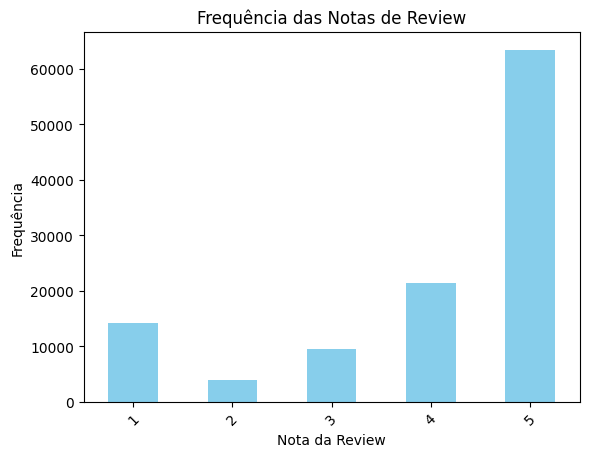

In [29]:
# Contar valores na coluna review_score e ordenar pelo índice (nota)
counts = df['review_score'].value_counts().sort_index()

# Criar gráfico de barras
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Nota da Review')
plt.xticks(rotation=45)
plt.ylabel('Frequência')
plt.title('Frequência das Notas de Review')
plt.show()

### Qual o ano de início e o fim dos reviews?

In [30]:
# Verificar desde qual ano são os reviews
df['review_creation_date'].min()

'2016-10-06 00:00:00'

In [31]:
df['review_creation_date'].max()

'2018-08-31 00:00:00'

### Quais estatísticas descritivas importantes dos preços dos produtos? 

In [32]:
# Média, Desvio Padrão, Preço Mínimo, Preço Máximo
df['price'].describe()

count    112372.000000
mean        120.378962
std         182.152386
min           0.850000
25%          39.900000
50%          74.900000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

In [33]:
# Mediana
df['price'].median()

74.9

In [34]:
#Moda
df['price'].mode()

0    59.9
Name: price, dtype: float64

## Processamento dos textos

### Nulos

- Para geração de embeddings, é necessário manter apenas os registros que contenham reviews presentes.

In [35]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113126,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,1.0,4fb209073dc2ab6a6d3c259a7c285501,5343d0649eca2a983820bfe93fc4d17e,2018-07-02 17:30:37,226.77,61.20
113127,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,1.0,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,2017-12-07 22:08:00,199.99,9.77
113128,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,2018-03-22 10:08:04,215.97,15.59
113129,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,1.0,73a7fbf8c1048131f3b531af31bcdf0e,8d956fec2e4337affcb520f56fd8cbfd,2018-06-26 18:15:29,50.95,15.46


In [36]:
df['review_score'].isnull().sum()

0

In [37]:
df['review_comment_title'] = df['review_comment_title'].fillna('')

C:\Users\Stella Sposito\AppData\Local\Temp\ipykernel_12996\266948004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_comment_title'] = df['review_comment_title'].fillna('')


In [38]:
df = df.dropna(subset=['review_comment_message'])

In [39]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85
5,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1.0,3880d25d502b15b1de6fddc42ad1d67a,989becdce12ebc39863c2bceab6f3ca1,2018-02-15 15:48:21,1199.00,134.25
13,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,1.0,61a4100ccd6d9c4c808a1fd954ddb8ad,05ff92fedb5be47920fea08e501238b9,2018-05-17 10:31:31,586.56,26.69
20,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78
24,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,1.0,6871a3c157d6f51697e887f3c3598479,974cf2cb8f4b7add98709c30df02fe10,2018-05-24 18:31:29,89.99,13.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113112,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00,2017-11-30 15:52:51,1.0,0bdd9a52d192d64770e33ae559512478,6560211a19b47992c3666cc44a7e94c0,2017-11-24 20:16:22,55.00,21.19
113115,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23,1.0,b5e2d4b3fa2f9ecad4c1df951afcc8ce,432c37c9dfba871172ec162e20118b8c,2018-02-08 16:00:30,160.00,8.71
113122,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06,1.0,79da264732f717f10ebf5d102aa6c32a,562fc2f2c2863ab7e79a9e4388a58a14,2018-05-18 17:31:40,29.99,12.79
113128,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,2018-03-22 10:08:04,215.97,15.59


In [40]:
df_duplicados = df[df.duplicated(subset='review_comment_message', keep=False)]

In [41]:
df_duplicados

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
28,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,1.0,55a1e3d39ace9c0b217f6c30b04d43c0,0be8ff43f22e456b4e0371b2245e4d01,2018-08-08 19:24:33,89.90,9.38
33,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25,1.0,c56ecdd06c754c22fc5c5245d9502e30,8b2492b7ff4468839593fafeed55bad9,2018-07-08 21:31:40,51.67,13.57
50,2170c9452c2216457b36003fe2969fbb,af32671d0b8ce510a94d9111d97371d3,5,,muito boa,2018-03-22 00:00:00,2018-03-30 23:37:25,1.0,93c480c7d11c68ba0a71e850da61b674,70a12e78e608ac31179aea7f8422044b,2018-03-22 03:29:31,149.00,13.48
52,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03,1.0,56b83ac081e4e6ea5f87323b4e46e85c,318f287a62ab7ac10b703ac37435a231,2017-03-22 14:36:05,59.00,31.70
53,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03,2.0,a87567bdce60de6f901e3d7c6d8df820,318f287a62ab7ac10b703ac37435a231,2017-03-22 14:36:05,85.00,30.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113100,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,2.0,a62e25e09e05e6faf31d90c6ec1aa3d1,634964b17796e64304cadf1ad3050fb7,2018-05-25 16:14:55,105.00,11.62
113101,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,3.0,a62e25e09e05e6faf31d90c6ec1aa3d1,634964b17796e64304cadf1ad3050fb7,2018-05-25 16:14:55,105.00,11.62
113102,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,4.0,a62e25e09e05e6faf31d90c6ec1aa3d1,634964b17796e64304cadf1ad3050fb7,2018-05-25 16:14:55,105.00,11.62
113103,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,5.0,a62e25e09e05e6faf31d90c6ec1aa3d1,634964b17796e64304cadf1ad3050fb7,2018-05-25 16:14:55,105.00,11.62


- Verificando reviews repetidas: o ideal é que o mesmo order_id, product_id e review contenham apenas uma review

In [42]:
# Verificar duplicados considerando as 3 colunas
df_duplicados = df[df.duplicated(subset=['order_id', 'product_id', 'review_comment_message'], keep=False)]

In [43]:
df_duplicados

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
52,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03,1.0,56b83ac081e4e6ea5f87323b4e46e85c,318f287a62ab7ac10b703ac37435a231,2017-03-22 14:36:05,59.00,31.70
54,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03,3.0,56b83ac081e4e6ea5f87323b4e46e85c,318f287a62ab7ac10b703ac37435a231,2017-03-22 14:36:05,59.00,31.70
85,109b5ce2dd11bb8460eff3b86da6fefc,25362fbf6aac4b01a28dee1e076acc26,5,Ótimo Produto!,Recomendo o vendedor...,2018-08-17 00:00:00,2018-08-17 21:47:08,1.0,7ae27ce0834f80f4e3779fd06ca9ce83,44ed138eca6214d572ce1d813fb0049b,2018-08-14 01:05:13,39.90,16.47
86,109b5ce2dd11bb8460eff3b86da6fefc,25362fbf6aac4b01a28dee1e076acc26,5,Ótimo Produto!,Recomendo o vendedor...,2018-08-17 00:00:00,2018-08-17 21:47:08,2.0,7ae27ce0834f80f4e3779fd06ca9ce83,44ed138eca6214d572ce1d813fb0049b,2018-08-14 01:05:13,39.90,16.47
92,8b230a1373c6dc4bd867099fda1d7039,071251fe3b3493294536f03737a8a679,3,,Eu comprei duas unidades e só recebi uma e ago...,2017-11-09 00:00:00,2017-11-10 10:38:37,1.0,d2085f7e0f9533605386960fc7e987ec,aac29b1b99776be73c3049939652091d,2017-11-06 02:56:07,12.49,15.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113100,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,2.0,a62e25e09e05e6faf31d90c6ec1aa3d1,634964b17796e64304cadf1ad3050fb7,2018-05-25 16:14:55,105.00,11.62
113101,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,3.0,a62e25e09e05e6faf31d90c6ec1aa3d1,634964b17796e64304cadf1ad3050fb7,2018-05-25 16:14:55,105.00,11.62
113102,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,4.0,a62e25e09e05e6faf31d90c6ec1aa3d1,634964b17796e64304cadf1ad3050fb7,2018-05-25 16:14:55,105.00,11.62
113103,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,5.0,a62e25e09e05e6faf31d90c6ec1aa3d1,634964b17796e64304cadf1ad3050fb7,2018-05-25 16:14:55,105.00,11.62


In [44]:
# Remover duplicados mantendo apenas a primeira ocorrência
df_clean = df.drop_duplicates(subset=['order_id', 'product_id', 'review_comment_message'])

In [45]:
df_clean

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85
5,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1.0,3880d25d502b15b1de6fddc42ad1d67a,989becdce12ebc39863c2bceab6f3ca1,2018-02-15 15:48:21,1199.00,134.25
13,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,1.0,61a4100ccd6d9c4c808a1fd954ddb8ad,05ff92fedb5be47920fea08e501238b9,2018-05-17 10:31:31,586.56,26.69
20,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78
24,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,1.0,6871a3c157d6f51697e887f3c3598479,974cf2cb8f4b7add98709c30df02fe10,2018-05-24 18:31:29,89.99,13.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113112,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00,2017-11-30 15:52:51,1.0,0bdd9a52d192d64770e33ae559512478,6560211a19b47992c3666cc44a7e94c0,2017-11-24 20:16:22,55.00,21.19
113115,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23,1.0,b5e2d4b3fa2f9ecad4c1df951afcc8ce,432c37c9dfba871172ec162e20118b8c,2018-02-08 16:00:30,160.00,8.71
113122,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06,1.0,79da264732f717f10ebf5d102aa6c32a,562fc2f2c2863ab7e79a9e4388a58a14,2018-05-18 17:31:40,29.99,12.79
113128,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,2018-03-22 10:08:04,215.97,15.59


In [46]:
df = df_clean

### Remoção de caracteres especiais

- Optei por manter pontuações porque podem conter perguntas ou exclamações

In [12]:
def remove_special_chars(text):
    if pd.isna(text) or text == '':
        return ''
    
    # Manter letras, números, acentos portugueses e pontuações básicas (sem hífen)
    text = re.sub(r'[^\w\s\.,!?;:()áéíóúãõçÁÉÍÓÚÃÕÇ]', '', text)
    
    # Remover reticências específicamente
    text = re.sub(r'\.{2,}', '', text)  # Remove 2 ou mais pontos consecutivos
    
    # Normalizar espaços múltiplos
    text = ' '.join(text.split())
    
    return text.strip()

In [13]:
# Aplicar na coluna
df['review_comment_message'] = df['review_comment_message'].apply(remove_special_chars)

C:\Users\Stella Sposito\AppData\Local\Temp\ipykernel_22740\303437540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_comment_message'] = df['review_comment_message'].apply(remove_special_chars)


- Verificando remoção de caracteres especiais e outras pontuações como: - e ...

In [14]:
# Configurar para mostrar texto completo
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Agora executar sua consulta
df[df['order_id'] == 'd5cb12269711bd1eaf7eed8fd32a7c95']['review_comment_message']

42538    O produto não foi enviado com NF, não existe venda sem NF, com certeza fico no aguardo do envio da NF podendo ser por email.
Name: review_comment_message, dtype: object

In [8]:
df = df.dropna(subset="review_comment_message")

In [15]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53,1.0,3880d25d502b15b1de6fddc42ad1d67a,989becdce12ebc39863c2bceab6f3ca1,2018-02-15 15:48:21,1199.00,134.25
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nomeatualizar com a marca correta uma vez que é o mesmo aparelho,2018-05-22 00:00:00,2018-05-23 16:45:47,1.0,61a4100ccd6d9c4c808a1fd954ddb8ad,05ff92fedb5be47920fea08e501238b9,2018-05-17 10:31:31,586.56,26.69
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travandopelo valor ta Boa.",2018-02-16 00:00:00,2018-02-20 10:52:22,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes do prazo.",2018-05-23 00:00:00,2018-05-24 03:00:01,1.0,6871a3c157d6f51697e887f3c3598479,974cf2cb8f4b7add98709c30df02fe10,2018-05-24 18:31:29,89.99,13.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42536,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,NaN,para este produto recebi de acordo com a compra realizada!,2017-11-29 00:00:00,2017-11-30 15:52:51,1.0,0bdd9a52d192d64770e33ae559512478,6560211a19b47992c3666cc44a7e94c0,2017-11-24 20:16:22,55.00,21.19
42537,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,NaN,Entregou dentro do prazo. O produto chegou em condições perfeitas. Estou muito satisfeita!,2018-02-07 00:00:00,2018-02-19 19:47:23,1.0,b5e2d4b3fa2f9ecad4c1df951afcc8ce,432c37c9dfba871172ec162e20118b8c,2018-02-08 16:00:30,160.00,8.71
42538,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,NaN,"O produto não foi enviado com NF, não existe venda sem NF, com certeza fico no aguardo do envio da NF podendo ser por email.",2018-05-19 00:00:00,2018-05-20 21:51:06,1.0,79da264732f717f10ebf5d102aa6c32a,562fc2f2c2863ab7e79a9e4388a58a14,2018-05-18 17:31:40,29.99,12.79
42539,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",2018-03-22 00:00:00,2018-03-23 09:10:43,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,2018-03-22 10:08:04,215.97,15.59


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42449 entries, 0 to 42540
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   review_id                42449 non-null  object 
 1   order_id                 42449 non-null  object 
 2   review_score             42449 non-null  int64  
 3   review_comment_title     10245 non-null  object 
 4   review_comment_message   42449 non-null  object 
 5   review_creation_date     42449 non-null  object 
 6   review_answer_timestamp  42449 non-null  object 
 7   order_item_id            42449 non-null  float64
 8   product_id               42449 non-null  object 
 9   seller_id                42449 non-null  object 
 10  shipping_limit_date      42449 non-null  object 
 11  price                    42449 non-null  float64
 12  freight_value            42449 non-null  float64
dtypes: float64(3), int64(1), object(9)
memory usage: 4.5+ MB


In [19]:
df['product_id'] = df['product_id'].astype(str)


C:\Users\Stella Sposito\AppData\Local\Temp\ipykernel_22740\1104597727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_id'] = df['product_id'].astype(str)


## Salva arquivo processado

In [21]:
df.to_csv("processed_text.csv", index=False)

## Verificações Embeddings

### Modelo Paraphrase Multilingual

In [51]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [52]:
# Gerar embeddings
embeddings = model.encode(df['review_comment_message'].tolist(), show_progress_bar=True)


Batches: 100%|██████████| 1330/1330 [12:38<00:00,  1.75it/s]


In [53]:
# Validando embeddings criadas
print(type(embeddings))              # Deve ser <class 'numpy.ndarray'>
print(embeddings.shape)              # Deve ser (n_reviews, 384)
print(embeddings.dtype)              # Deve ser float32 ou float64

<class 'numpy.ndarray'>
(42541, 384)
float32


In [54]:
embeddings

array([[ 0.04877248,  0.27656892,  0.02244522, ...,  0.12824756,
        -0.17149335, -0.10284543],
       [ 0.18253353,  0.00096162,  0.03586172, ..., -0.02506845,
        -0.14335485,  0.1592602 ],
       [-0.21734957,  0.08266209, -0.06797412, ..., -0.04882071,
         0.3687101 ,  0.2450473 ],
       ...,
       [-0.30416146,  0.06389321, -0.1514633 , ..., -0.28128386,
         0.04072457,  0.04197485],
       [-0.04257644,  0.0661599 , -0.11396654, ..., -0.31656456,
        -0.27918366,  0.13139565],
       [-0.12102566,  0.087088  ,  0.04620608, ..., -0.3393524 ,
         0.04397958, -0.07511465]], dtype=float32)

In [55]:
print(embeddings[0])  # Vetor do primeiro review

[ 4.87724841e-02  2.76568919e-01  2.24452224e-02 -1.95160732e-02
 -1.24417676e-03  2.65487935e-02 -9.92362797e-02  2.80364364e-01
  1.92342758e-01 -6.28046766e-02  2.79263388e-02 -2.93631181e-02
  2.88061291e-01 -2.19041824e-01 -2.49231592e-01 -2.54434139e-01
  1.52959853e-01 -3.23513687e-01 -8.23831633e-02 -2.22583130e-01
 -2.11597785e-01  3.05728670e-02 -3.66565846e-02  1.93202972e-01
  4.19082910e-01  9.28807538e-04 -9.42771062e-02 -1.41875632e-03
 -1.69836003e-02 -1.11519538e-01 -1.88913897e-01 -2.44999424e-01
  3.16779912e-01 -1.36335358e-01  5.04392684e-02 -9.32825077e-03
  1.79478005e-01  3.48049738e-02  1.10611357e-01 -1.25886127e-01
 -2.54263040e-02 -1.83428988e-01 -5.99921085e-02  2.64735311e-01
  1.60796255e-01  2.99578071e-01 -1.27710775e-01  2.08009686e-02
 -1.85548082e-01  2.38178864e-01  1.61456242e-01  1.65188819e-01
 -5.84970452e-02  1.05116241e-01  1.66209355e-01  2.18987271e-01
  3.69284116e-03  2.92194635e-03  1.18458577e-01  4.15024161e-01
 -4.26031679e-01 -9.73159

In [57]:
# 1. Inicializa o ChromaDB em modo persistente
chroma_client = chromadb.Client(Settings(
    persist_directory="chroma_reviews_db",  # pasta para persistência
    anonymized_telemetry=False
))

# 2. Cria coleção (ou pega se já existir)
collection = chroma_client.get_or_create_collection(
    name="reviews_collection"
)


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [59]:
# 3. Preparar dados para inserção

# IDs únicos para cada vetor (Chroma exige isso)
ids = [str(uuid4()) for _ in range(len(df))]

# Textos (reviews limpos)
documents = df['review_comment_message'].tolist()

# Metadados: product_id e review_score
metadatas = [
    {
        "product_id": pid,
        "review_score": int(score)
    }
    for pid, score in zip(df['product_id'], df['review_score'])
]

# Inserir na coleção com embeddings já calculadas
BATCH_SIZE = 5000

n = len(df)
for i in range(0, n, BATCH_SIZE):
    print(f"Inserindo batch {i} a {min(i + BATCH_SIZE, n)}...")
    
    batch_ids = ids[i:i+BATCH_SIZE]
    batch_docs = documents[i:i+BATCH_SIZE]
    batch_embeddings = embeddings[i:i+BATCH_SIZE].tolist()
    batch_metadatas = metadatas[i:i+BATCH_SIZE]

    collection.add(
        ids=batch_ids,
        documents=batch_docs,
        embeddings=batch_embeddings,
        metadatas=batch_metadatas
    )

Inserindo batch 0 a 5000...


Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


Inserindo batch 5000 a 10000...
Inserindo batch 10000 a 15000...
Inserindo batch 15000 a 20000...
Inserindo batch 20000 a 25000...
Inserindo batch 25000 a 30000...
Inserindo batch 30000 a 35000...
Inserindo batch 35000 a 40000...
Inserindo batch 40000 a 42541...


In [60]:
# Verifique a coleção existente
collection = chroma_client.get_collection("reviews_collection")  # Nome da coleção original
print("Número de registros:", collection.count())  # Verifique se os dados estão lá

Número de registros: 42541


In [62]:
# Exemplo: buscar todos os reviews de um product_id específico
product_id_example = "8ba0118a487ec8671aed57e5ef846574"  # Substitua por um ID existente
results = collection.get(
    where={"product_id": product_id_example}  # Filtro nos metadados
)
print(f"Reviews do produto {product_id_example}:", results["documents"], results["metadatas"])

Reviews do produto 8ba0118a487ec8671aed57e5ef846574: ['tive a felicidade de ter uma filial da empresa no estado em que deveria ser entregue o que facilitou bastante o prazo, satisfeito!', 'Excelente mochila, entrega super rápida. Super recomendo essa loja!', 'Entregue no tempo correto', 'Comprei produto da foto e recebi outro bem inferior, me sentindo enganada. Sem respaldo para devoluçao,'] [{'product_id': '8ba0118a487ec8671aed57e5ef846574', 'review_score': 5}, {'product_id': '8ba0118a487ec8671aed57e5ef846574', 'review_score': 5}, {'product_id': '8ba0118a487ec8671aed57e5ef846574', 'review_score': 5}, {'product_id': '8ba0118a487ec8671aed57e5ef846574', 'review_score': 1}]


### Busca no banco de dados vetorial

In [70]:
def get_reviews_by_product_id(collection, product_id: str, n_results: int = 30):
    result = collection.query(
        query_texts=[" "],  # placeholder
        where={"product_id": product_id},
        n_results=n_results
    )

    # Chroma retorna listas aninhadas: [[...]]
    documents = result.get("documents", [[]])[0]
    metadatas = result.get("metadatas", [[]])[0]

    # Junta textos e metadados
    reviews_with_scores = [
        {"text": doc, "score": meta.get("review_score", None)}
        for doc, meta in zip(documents, metadatas)
    ]

    return reviews_with_scores


In [71]:
product_id_exemplo = df['product_id'].value_counts().idxmax()  # pega um product_id com mais reviews

reviews = get_reviews_by_product_id(collection, product_id_exemplo)

print(f"Número de reviews encontrados: {len(reviews)}")
for r in reviews[:3]:
    print("-", r)


Número de reviews encontrados: 30
- {'text': 'SÓ PEÇO QUE MEU PEDIDO CHEGUE PORQUE ESTOU AGUARDANDO COM ANSIEDADE.', 'score': 4}
- {'text': 'NÃO GOSTEI DA QUALIDADE DAS TOALHAS, ESTOU SOLICITANDO A DEVOLUÇÃO', 'score': 1}
- {'text': 'Super macia, adorei recomendo sim', 'score': 5}


## Análise de Sentimentos

In [73]:
# Cria pipeline de análise de sentimento
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

c:\Users\Stella Sposito\Desktop\api\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Stella Sposito\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cpu


In [76]:
def analyze_reviews_sentiment(reviews_with_scores: list):
    texts = [r["text"] for r in reviews_with_scores]
    scores = [r["score"] for r in reviews_with_scores]
    sentiment_results = sentiment_pipeline(texts)

    def map_bert_multilingual_stars(label: str) -> str:
        stars = int(label[0])
        if stars <= 2:
            return "Negativo"
        elif stars == 3:
            return "Neutro"
        else:
            return "Positivo"

    def classificar_por_nota(score: int) -> str:
        if score is None:
            return "Desconhecido"
        if 0 <= score <= 2:
            return "Insatisfeito"
        elif score == 3:
            return "Razoável"
        elif score == 4:
            return "Satisfeito"
        elif score == 5:
            return "Muito Satisfeito"
        return "Nota inválida"

    output = []
    for text, sent_res, nota in zip(texts, sentiment_results, scores):
        sentimento_texto = map_bert_multilingual_stars(sent_res['label'])
        confidence = round(sent_res['score'], 3)
        output.append({
            "text": text,
            "sentiment_texto": sentimento_texto,
            "sentiment_nota": classificar_por_nota(nota),
            "review_score": nota,
            "confidence": confidence
        })
    return output

In [77]:
reviews = get_reviews_by_product_id(collection, product_id_exemplo)

# Isso deve ser uma lista de dicionários
print(reviews[:2])

resultado = analyze_reviews_sentiment(reviews[:10])
from pprint import pprint
pprint(resultado)


[{'text': 'SÓ PEÇO QUE MEU PEDIDO CHEGUE PORQUE ESTOU AGUARDANDO COM ANSIEDADE.', 'score': 4}, {'text': 'NÃO GOSTEI DA QUALIDADE DAS TOALHAS, ESTOU SOLICITANDO A DEVOLUÇÃO', 'score': 1}]
[{'confidence': 0.362,
  'review_score': 4,
  'sentiment_nota': 'Satisfeito',
  'sentiment_texto': 'Neutro',
  'text': 'SÓ PEÇO QUE MEU PEDIDO CHEGUE PORQUE ESTOU AGUARDANDO COM '
          'ANSIEDADE.'},
 {'confidence': 0.769,
  'review_score': 1,
  'sentiment_nota': 'Insatisfeito',
  'sentiment_texto': 'Negativo',
  'text': 'NÃO GOSTEI DA QUALIDADE DAS TOALHAS, ESTOU SOLICITANDO A DEVOLUÇÃO'},
 {'confidence': 0.757,
  'review_score': 5,
  'sentiment_nota': 'Muito Satisfeito',
  'sentiment_texto': 'Positivo',
  'text': 'Super macia, adorei recomendo sim'},
 {'confidence': 0.511,
  'review_score': 5,
  'sentiment_nota': 'Muito Satisfeito',
  'sentiment_texto': 'Positivo',
  'text': 'recomendo'},
 {'confidence': 0.805,
  'review_score': 1,
  'sentiment_nota': 'Insatisfeito',
  'sentiment_texto': 'Negati

## Verificações LLM

In [113]:
# Configuração do ChromaDB
def get_chroma_collection():
    chroma_client = chromadb.Client(Settings(
        persist_directory="chroma_reviews_db",
        anonymized_telemetry=False
    ))
    return chroma_client.get_collection("reviews_collection")

# Parsing da resposta com tolerância a erros
def parse_llm_response(response_text):
    try:
        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
        if json_match:
            return json.loads(json_match.group())
    except Exception as e:
        print(f"[!] Erro ao parsear JSON: {e}")
    
    return {
        "sentiment": "Neutro",
        "summary": "Resumo não disponível",
        "positive_points": [],
        "negative_points": []
    }

# Função principal com pipelines separados
def sentiment_analyzer(product_id: str) -> dict:
    # 1. Buscar reviews
    collection = get_chroma_collection()
    results = collection.get(
        where={"product_id": product_id},
        include=["documents", "metadatas"]
    )
    
    if not results['ids']:
        return {
            "sentiment": "Neutro",
            "summary": "Nenhum review encontrado para este produto",
            "positive_points": [],
            "negative_points": [],
            "top_reviews": []
        }

    reviews = results['documents']
    reviews_text = " ".join(reviews)[:4000]  # Limitar texto para evitar estouro

    # 2. Pipeline de resumo
    summarizer = pipeline(
        "summarization",
        model="facebook/bart-large-cnn",
        device=-1  # CPU
    )

    prompt_text = f"Resuma os seguintes reviews de produto, explicando se o produto foi elogiado ou criticado. Exemplo: O produto foi amplamente elogiado por tais motivos: {reviews_text}"

    summary_output = summarizer(prompt_text, max_length=60, min_length=20, do_sample=False)
    summary = summary_output[0]['summary_text']

    # 3. Pipeline de análise de sentimentos
    sentiment_classifier = pipeline(
        "sentiment-analysis",
        model="nlptown/bert-base-multilingual-uncased-sentiment",  # bom para português
        device=-1
    )
    
    # Analisar sentimento de cada review e agregar
    sentiments = [sentiment_classifier(review)[0] for review in reviews]
    
    # Contar sentimentos para definir sentimento geral
    sentiment_scores = {"POSITIVE": 0, "NEGATIVE": 0, "NEUTRAL": 0}
    for s in sentiments:
        label = s['label'].upper()
        if "NEGATIVE" in label or label.startswith("1") or label.startswith("2"):
            sentiment_scores["NEGATIVE"] += 1
        elif "POSITIVE" in label or label.startswith("4") or label.startswith("5"):
            sentiment_scores["POSITIVE"] += 1
        else:
            sentiment_scores["NEUTRAL"] += 1

    if sentiment_scores["POSITIVE"] > sentiment_scores["NEGATIVE"]:
        overall_sentiment = "Positivo"
    elif sentiment_scores["NEGATIVE"] > sentiment_scores["POSITIVE"]:
        overall_sentiment = "Negativo"
    else:
        overall_sentiment = "Neutro"

    # 4. Extrair pontos positivos e negativos simples (exemplo baseado em frases)
    positive_points = [r for r, s in zip(reviews, sentiments) if s['label'].upper().startswith("4") or s['label'].upper().startswith("5")]
    negative_points = [r for r, s in zip(reviews, sentiments) if s['label'].upper().startswith("1") or s['label'].upper().startswith("2")]

    # Limitar número de pontos para não ficar muito longo
    positive_points = positive_points[:5]
    negative_points = negative_points[:5]

    # 5. Reviews representativos
    top_reviews = [re.sub(r'\s+', ' ', review.strip())[:200] for review in reviews[:3]]

    return {
        "sentiment": overall_sentiment,
        "summary": summary,
        "positive_points": positive_points,
        "negative_points": negative_points,
        "top_reviews": top_reviews
    }



In [117]:
# Exemplo de uso
if __name__ == "__main__":
    resultado = sentiment_analyzer("8ba0118a487ec8671aed57e5ef846574")
    print(json.dumps(resultado, indent=2, ensure_ascii=False))

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Device set to use cpu
Device set to use cpu


{
  "sentiment": "Positivo",
  "summary": "O produto foi amplamente elogiado por tais motivos: tive a felicidade de ter uma filial da empresa no estado em which deveria ser entregue. Excelente mochila, entrega super",
  "positive_points": [
    "tive a felicidade de ter uma filial da empresa no estado em que deveria ser entregue o que facilitou bastante o prazo, satisfeito!",
    "Excelente mochila, entrega super rápida. Super recomendo essa loja!"
  ],
  "negative_points": [
    "Comprei produto da foto e recebi outro bem inferior, me sentindo enganada. Sem respaldo para devoluçao,"
  ],
  "top_reviews": [
    "tive a felicidade de ter uma filial da empresa no estado em que deveria ser entregue o que facilitou bastante o prazo, satisfeito!",
    "Excelente mochila, entrega super rápida. Super recomendo essa loja!",
    "Entregue no tempo correto"
  ]
}
